In [1]:
import sys, os
PATH = os.path.dirname(os.path.abspath(os.curdir))
if PATH not in sys.path:
    sys.path.insert(0, PATH)

import logging

logging.basicConfig(level=logging.ERROR)
logging.getLogger("torch").setLevel(logging.ERROR)
logging.getLogger("transformers").setLevel(logging.ERROR)

from pathos.multiprocessing import ProcessPool
import src.Simulator as sim_system
import src.Optimizer as opt
import src.SimGrad as sim_diff
import scipy as sp
import numpy as np
import torch
import tqdm


###* Create Simulator object
reactions_file = "../reactions/reactionsSimpleV1.json"

const_dict = {
        "F0": 1.5e15,           # cm^-2
        "S0": 3e13,             # cm^-2
        
        "R": 0.00831442,        # kJ/mol*K
        "kBoltz": 1.380649e-23, # J/K
}

initial_state_dict = {'O_F': 0.1, 'O2_F':0.1 ,'O_S': 0.1, 'Vdb_S':0.1, 
                    'Odb_S': 0.1, 'CO_F': 0.1, 'CO2_F':0.1, 'CO_S': 0.1, 
                    'COdb_S': 0.0}

###* Functions for the data transformation
def compute_flux(const_dict, exp_dict, specie, molar_mass):
    den = exp_dict.get(specie, 0.0)
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux


def compute_remaining_flux(const_dict, exp_dict, molar_mass): 
    den = exp_dict['N'] - exp_dict['O'] - exp_dict['CO']
    v_th = np.sqrt((8.0 * const_dict['R'] * 1000 * exp_dict['Tnw'])/(molar_mass * np.pi))
    flux = 0.25 * v_th * den * 100
    return flux

####? EavgMB data extracted from the Booth et al. 2019 paper
p_data_exp = [0.2, 0.3, 0.4, 0.5, 0.6, 0.75, 1.5]
EavgMB_data = [1.04, 0.91, 0.87, 0.83, 0.77, 0.5, 0.001]
interpolator = sp.interpolate.interp1d(p_data_exp, EavgMB_data, kind='linear', fill_value=0.001, bounds_error=False)


transformations_exp = {
    'Tw':       lambda const_dict, exp_dict: exp_dict['Tw'] + 273.15,
    'fluxO' :   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O', 0.016),
    'fluxO2' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O2', 0.032),
    'fluxO3' :  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict,'O3', 0.048),
    'fluxC':    lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'C', 0.012),
    'fluxCO':   lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO', 0.028),
    'fluxCO2':  lambda const_dict, exp_dict: compute_flux(const_dict, exp_dict, 'CO2', 0.048),
    'EavgMB':   lambda const_dict, exp_dict: interpolator(exp_dict['pressure']).item(),
    'Ion':      lambda const_dict, exp_dict: 1e14 * exp_dict["current"]
}

output_folder_path = "../Buffer_Data"
exp_data_file = "Experimental_data_CO_Jorge.hdf5"
exp_file = os.path.join(output_folder_path, exp_data_file)

sim = sim_system.Simulator(reactions_file, const_dict, exp_file, initial_state_dict, transformations_exp=transformations_exp)


  d[CO2_F]/dt = -CO2_F*r_29 + r_28*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_F*O_S*r_39 - CO_F*r_31 - CO_F*r_33 - 0.02*CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_30*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[CO_S]/dt = CO_F*r_35*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - CO_S*O_F*r_38 - CO_S*r_36 + r_32*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[O2_F]/dt = -O2_F*O_F*r_15 - O2_F*r_10 - O2_F*r_12 - O2_F*r_14 + r_9*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_F]/dt = -CO_F*O_F*r_34 - 0.02*CO_S*O_F*r_38 - O2_F*O_F*r_15 - 2*O_F**2*r_8 - 0.02*O_F*O_S*r_7 - 0.02*O_F*Odb_S*r_27 - 0.02*O_F*Vdb_S*r_26 - O_F*r_11 - O_F*r_2 - O_F*r_4 - 0.02*O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) + r_1*(-CO2_F - CO_F - O2_F - O_F + 1.0)
  d[O_S]/dt = -CO_F*O_S*r_39 - O_F*O_S*r_7 + O_F*r_5*(-CO_S - O_S - Odb_S - Vdb_S + 1.0) - O_S*r_16 - O_S*r_17 - O_S*r_37 - O_S*r_6 + r_3*(-CO_S - O_S - Odb_S - Vdb_S + 1.0)
  d[Odb_S]/dt = -O_F*Odb_S*r_27 + O_F*Vdb_S*r_26 - Odb_S*r_23 - Odb_S*r_24 - Odb

In [2]:
###* Create optimization and diff objects with the proper bounds
lower_bounds = np.array([1e-8, 1e-8, 0.0, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5, \
                    1e-5, 1e-5, 1e-5, 1e-5, 1e-5
                    ])

upper_bounds = np.array([5e-1, 1e-5, 30.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0, \
                    1.0, 1.0, 1.0, 1.0, 1.0
                    ])

##! define parameters to optimize
def func_optimization(params, flag='numpy'):
    
    A_d, B_d, E_d, SF_1, SF_2, SF_3, SF_4, SF_5, SF_6, SF_7, SF_8, SF_9, SF_10 = params
    
    A_d = lower_bounds[0] + (upper_bounds[0] - lower_bounds[0]) * A_d
    B_d = lower_bounds[1] + (upper_bounds[1] - lower_bounds[1]) * B_d
    E_d = lower_bounds[2] + (upper_bounds[2] - lower_bounds[2]) * E_d
    
    SF_1 = lower_bounds[3] + (upper_bounds[3] - lower_bounds[3]) * SF_1
    SF_2 = lower_bounds[4] + (upper_bounds[4] - lower_bounds[4]) * SF_2
    SF_3 = lower_bounds[5] + (upper_bounds[5] - lower_bounds[5]) * SF_3
    SF_4 = lower_bounds[6] + (upper_bounds[6] - lower_bounds[6]) * SF_4
    SF_5 = lower_bounds[7] + (upper_bounds[7] - lower_bounds[7]) * SF_5
    
    SF_6 = lower_bounds[8] + (upper_bounds[8] - lower_bounds[8]) * SF_6
    SF_7 = lower_bounds[9] + (upper_bounds[9] - lower_bounds[9]) * SF_7
    SF_8 = lower_bounds[10] + (upper_bounds[10] - lower_bounds[10]) * SF_8
    SF_9 = lower_bounds[11] + (upper_bounds[11] - lower_bounds[11]) * SF_9
    SF_10 = lower_bounds[12] + (upper_bounds[12] - lower_bounds[12]) * SF_10
    
    if flag=='numpy':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * np.exp(E_d/(const_dict['R'] * T)))
    elif flag=='torch':
        nu_d_mod = lambda T: 1e15 * (A_d + B_d * torch.exp(E_d/(const_dict['R'] * T)))
    else:
        raise ValueError(f"{flag} does not exist")
    
    dict_mod_vec = [
    {"id": 2, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 10, "rate": None, "model_dict": {"nu_d": nu_d_mod}},
    {"id": 31, "rate": None, "model_dict": {"SF": SF_2, "nu_d": nu_d_mod}},
    
    {"id": 30, "rate": None, "model_dict": {"SF": SF_1}},
    # {"id": 31, "rate": None, "model_dict": {"SF": SF_2}},
    {"id": 32, "rate": None, "model_dict": {"SF": SF_3}},
    {"id": 33, "rate": None, "model_dict": {"SF": SF_4}},
    {"id": 34, "rate": None, "model_dict": {"SF": SF_5}},
    
    {"id": 35, "rate": None, "model_dict": {"SF": SF_6}},
    {"id": 36, "rate": None, "model_dict": {"SF": SF_7}},
    {"id": 37, "rate": None, "model_dict": {"SF": SF_8}},
    {"id": 38, "rate": None, "model_dict": {"SF": SF_9}},
    {"id": 39, "rate": None, "model_dict": {"SF": SF_10}},
    ]
    
    return dict_mod_vec

##! define the default parameters
params_default = []
params_default_aux = list((0.01634, 1.67e-4, 19.75, \
                1.0, 1.0, 1e-2, 1e-1, 1e-1, \
                1e-2, 1e-1, 1e-1, 1e-1, 1e-1
                ))
for idx, param in enumerate(params_default_aux):
    value = (param - lower_bounds[idx])/(upper_bounds[idx] - lower_bounds[idx])
    params_default.append(value)

params_default = tuple(params_default)
print("params_default: ", params_default)

def loss_function(exp, teo, flag='numpy'):
    
    func = ((teo-exp)**2)/(exp**2)
    if flag == 'numpy':
        return np.mean(func)
    elif flag == 'torch':
        return torch.mean(func)
    else:
        raise ValueError(f"{flag} does not exist")


optimizer = opt.Optimizer(sim, 
                        lambda params: func_optimization(params, 'numpy'), 
                        lambda exp, teo: loss_function(exp, teo, 'numpy')
                        )

diff = sim_diff.SimDiff(sim, 
                        lambda params: func_optimization(params, 'torch'),
                        params_default=params_default,
                        gamma_exp_data=sim.gamma_exp_data_arr,
                        loss_function=lambda exp, teo: loss_function(exp, teo, 'torch')
                        )


params_default:  (0.03267998065359961, 16.715715715715714, 0.6583333333333333, 1.0, 1.0, 0.00999009990099901, 0.0999909999099991, 0.0999909999099991, 0.00999009990099901, 0.0999909999099991, 0.0999909999099991, 0.0999909999099991, 0.0999909999099991)
rx_update_vec:  ['r_2', 'r_10', 'r_31', 'r_30', 'r_32', 'r_33', 'r_34', 'r_35', 'r_36', 'r_37', 'r_38', 'r_39'] 12
rx_no_update_vec:  ['r_1', 'r_3', 'r_4', 'r_5', 'r_6', 'r_7', 'r_8', 'r_9', 'r_11', 'r_12', 'r_14', 'r_15', 'r_16', 'r_17', 'r_18', 'r_19', 'r_20', 'r_21', 'r_22', 'r_23', 'r_24', 'r_25', 'r_26', 'r_27', 'r_28', 'r_29']


In [3]:
# def loss_and_grads(params, opt_object, diff_object):
#     loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
#     grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
#     # print("loss_val: ", loss_val, "grad_val: ", grad_val, "params: ", params)
#     # print("loss_val: ", loss_val)
#     return loss_val, grad_val.numpy()


def loss_and_grads(params, opt_object, diff_object):
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    # grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    # print("loss_val: ", loss_val, "grad_val: ", grad_val, "params: ", params)
    # print("loss_val: ", loss_val)
    return loss_val

In [4]:
print(params_default)
print(len(params_default))

(0.03267998065359961, 16.715715715715714, 0.6583333333333333, 1.0, 1.0, 0.00999009990099901, 0.0999909999099991, 0.0999909999099991, 0.00999009990099901, 0.0999909999099991, 0.0999909999099991, 0.0999909999099991, 0.0999909999099991)
13


In [5]:

loss_val = loss_and_grads(params_default, optimizer, diff)

print(loss_val)

0.11222424225336039


In [6]:


def grads(params, opt_object, diff_object):
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    grad_val = diff_object.objective_function_grad(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    # print("loss_val: ", loss_val, "grad_val: ", grad_val, "params: ", params)
    # print("loss_val: ", loss_val)
    return grad_val.numpy()


def grads_wise(params, opt_object, diff_object):
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    grad_val = diff_object.objective_function_grad_element_wise(params, frac_solutions_arr, rates_arr, gammas_predicted_arr)
    # print("loss_val: ", loss_val, "grad_val: ", grad_val, "params: ", params)
    # print("loss_val: ", loss_val)
    return grad_val.numpy()

In [7]:

grads_val = grads(params_default, optimizer, diff)

print(grads_val)

[-1.99182384e+01 -6.87047729e-01 -1.30721298e+02 -8.06332614e+00
 -1.21316643e+01 -2.02025640e-04  1.28716850e-04 -7.00524873e+00
 -1.05356400e-01  1.19004749e-02  1.06162163e-04  2.09839589e-04
  9.43306574e-07]


In [8]:
print(sim.gamma_exp_data_arr.shape)

(94,)


In [9]:
grads_wise = -grads_wise(params_default, optimizer, diff) / sim.gamma_exp_data_arr.reshape(-1, 1)
F_matrix = np.matmul(grads_wise.T, grads_wise)


# print(grads_wise_val.shape)
print(grads_wise.shape)

(94, 13)


In [10]:
eigenvalues, eigenvector = np.linalg.eigh(F_matrix)

idx = np.argsort(np.abs(eigenvalues))[::-1]
eigvals_sorted = eigenvalues[idx]
eigvecs_sorted = eigenvector[:,idx]

total_info = np.sum(np.abs(eigvals_sorted))

cumulative = np.cumsum(np.abs(eigvals_sorted))
threshold = 0.90 * total_info
num_components = np.searchsorted(cumulative, threshold) + 1


eigvals_selected = eigvals_sorted[:num_components]
eigvecs_selected = eigvecs_sorted[:,:num_components]


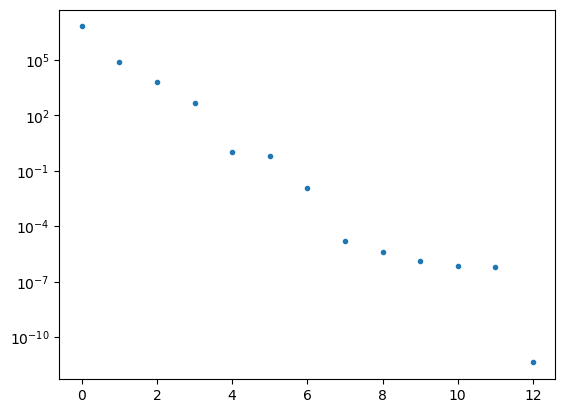

In [11]:
import matplotlib.pyplot as plt

plt.plot(eigvals_sorted, '.')
plt.yscale('log')

In [12]:

Vs = eigvecs_selected
Vl = eigvecs_sorted[:,num_components:]

theta0 = np.array(params_default)
phi0 = np.linalg.solve(eigvecs_sorted,theta0)


In [13]:
theta0 = np.matmul(eigvecs_sorted, phi0)
print(theta0)

[3.26799807e-02 1.67157157e+01 6.58333333e-01 1.00000000e+00
 1.00000000e+00 9.99009990e-03 9.99909999e-02 9.99909999e-02
 9.99009990e-03 9.99909999e-02 9.99909999e-02 9.99909999e-02
 9.99909999e-02]


In [14]:
print(np.dot(Vs, phi0[0]))
print(np.dot(Vl, phi0[1:]))
print()
print(np.dot(Vs, phi0[0]).squeeze() + np.dot(Vl, phi0[1:]) )

[[ 1.25749793e-01]
 [ 4.52587694e-03]
 [ 8.67738961e-01]
 [ 4.39347982e-02]
 [ 7.97411406e-02]
 [ 1.21707050e-06]
 [-6.39023558e-07]
 [ 3.98516173e-02]
 [ 4.77496757e-04]
 [-7.89795340e-05]
 [-4.60108196e-07]
 [-7.28323338e-07]
 [-2.86627905e-09]]
[-9.30698126e-02  1.67111898e+01 -2.09405627e-01  9.56065202e-01
  9.20258859e-01  9.98888283e-03  9.99916389e-02  6.01393826e-02
  9.51260314e-03  1.00069979e-01  9.99914600e-02  9.99917282e-02
  9.99910028e-02]

[3.26799807e-02 1.67157157e+01 6.58333333e-01 1.00000000e+00
 1.00000000e+00 9.99009990e-03 9.99909999e-02 9.99909999e-02
 9.99009990e-03 9.99909999e-02 9.99909999e-02 9.99909999e-02
 9.99909999e-02]


In [15]:

def loss_new(phi, Vs, Vl, opt_object, diff_object):
    
    params_aux = np.dot(Vs, phi).reshape(-1) + np.dot(Vl, phi0[1:]).reshape(-1)
    params = tuple(np.abs(params_aux).reshape(-1))    
    
    loss_val, frac_solutions_arr, rates_arr, _, gammas_predicted_arr = opt_object.objective_function_diff(params)
    return loss_val

In [26]:

phiVec = np.linspace(0.87, 0.9, 10)
lossVec = np.zeros_like(phiVec)

for idx, phi in enumerate(phiVec):
    lossVec[idx] = loss_new(phi, Vs, Vl, optimizer, diff)
    
    print(idx)
        

0
1
2
3
4
5
6
7
8
9


In [27]:
print(lossVec)

[0.35078053 0.26126068 0.19229803 0.14061958 0.10342748 0.07833207
 0.06329431 0.05657624 0.05669838 0.06240302]


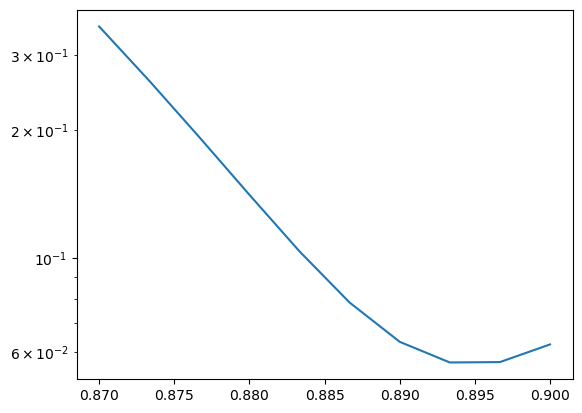

In [28]:
plt.figure()
plt.plot(phiVec, lossVec)
plt.yscale('log')
# plt.ylim(0.0, 0.5)
# plt.yscale('log')

In [19]:
# eigenvalues, eigenvector = np.linalg.eigh(F_matrix)

# print(eigenvalues.real)

# print(eigenvector[-1])